In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import to_json_friendly_tree, running_mean
import numpy as np

import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize

import gzip
import json
import os
from datetime import datetime

from utils import running_mean

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)



IMAGEDIR = "./images/scratch/"
DRYRUN = False
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        dir = os.path.dirname(filepath)
        if not os.path.exists(dir):
            os.makedirs(dir, exist_ok=True)
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


def _read_json_file(filepath):
    assert filepath.endswith(".json") or filepath.endswith(".json.gz")
    if filepath.endswith(".json"):
        with open(filepath, "r") as f:
            data = json.load(f)
    else:
        with gzip.open(filepath, "rb") as f:
            data = json.load(f)
    return data


In [73]:
# _ID = 10
_datadir_prefix = "./spartan_outputs/multitask_sparse_parity_expt/prod/"
_datadir_name = "multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314"
DATA_DIR = os.path.join(_datadir_prefix, _datadir_name)
IMAGEDIR = os.path.join(
    "./images/spartan/multitask_sparse_parity/",
    f"{_datadir_name}", 
)
print(f"Data directory: {DATA_DIR}")
print(f"Image directory: {IMAGEDIR}")

def extract_directory(dir_path):
    filelist = os.listdir(dir_path)
    # print(f"Extracting directory: {dir_path}. Found {len(filelist)} files: \n   {filelist}")
    config_filename = "config.json" if "config.json" in filelist else "config.json.gz"
    info_filename = "info.json" if "info.json" in filelist else "info.json.gz"
    run_filename = "run.json" if "run.json" in filelist else "run.json.gz"
    expt_config = _read_json_file(os.path.join(dir_path, config_filename))
    expt_info = _read_json_file(os.path.join(dir_path, info_filename))
    expt_run_rec = _read_json_file(os.path.join(dir_path, run_filename))
    return expt_config, expt_info, expt_run_rec


def extract_expt_group(dir_path): 
    success_group = {}
    failed_group = {}
    for expt_dir in os.listdir(dir_path):
        expt_dir_path = os.path.join(dir_path, expt_dir)
        if os.path.isdir(expt_dir_path) and any([f.startswith("info.json") for f in os.listdir(expt_dir_path)]):
            expt_config, expt_info, expt_run_rec = extract_directory(expt_dir_path)
            if expt_run_rec["status"] != "COMPLETED": 
                failed_group[expt_dir] = {
                    "config": expt_config,
                    "info": expt_info,
                    "run": expt_run_rec
                }
                print(f"Failed experiment: {expt_dir}")
            else:
                success_group[expt_dir] = {
                    "config": expt_config,
                    "info": expt_info
                }
    return success_group, failed_group

expt_records, failed_records = extract_expt_group(DATA_DIR)
if len(failed_records) > 0:
    print(f"WARNING: Found {len(failed_records)} failed experiments.")
    

Data directory: ./spartan_outputs/multitask_sparse_parity_expt/prod/multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314
Image directory: ./images/spartan/multitask_sparse_parity/multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314
Failed experiment: 9
Failed experiment: 1
Failed experiment: 5


# Plot one experiment

In [74]:
_ID = "9"
# records = expt_records[_ID]
records = failed_records[_ID]
expt_info = records["info"]
expt_config = records["config"]
print(json.dumps(expt_config, indent=2))

num_parameters = expt_info["expt_properties"]["num_parameters"]
print(f"Number of parameters: {num_parameters}")

df_sgd = pd.DataFrame(expt_info["sgd_records"])
do_llc_estimation = expt_config["do_llc_estimation"]

{
  "burn_in_prop": 0.9,
  "data_config": {
    "alpha": 0.4,
    "n_subset_size": 3,
    "n_taskbits": 50,
    "n_tasks": 30,
    "num_test_samples": 20000,
    "num_training_samples": 100000
  },
  "dataset_seed": null,
  "do_llc_estimation": true,
  "do_taskwise_training": true,
  "expt_name": "multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314",
  "log_sgld_loss_trace": false,
  "logging_period": 1000,
  "max_num_stages": 10,
  "model_config": {
    "hidden_layer_widths": [
      8192,
      8192,
      8192
    ],
    "model_type": "mlp"
  },
  "seed": 0,
  "sgld_config": {
    "batch_size": null,
    "epsilon": 5e-06,
    "gamma": 1.0,
    "num_chains": 3,
    "num_steps": 1000
  },
  "taskwise_training_num_steps": 50000,
  "training_config": {
    "batch_size": 1024,
    "early_stopping_loss_threshold": 1e-08,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "num_steps": 500000,
    "optim": "adam"


Saving file at: ./images/spartan/multitask_sparse_parity/multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314/sgd_analysis_id9.pdf


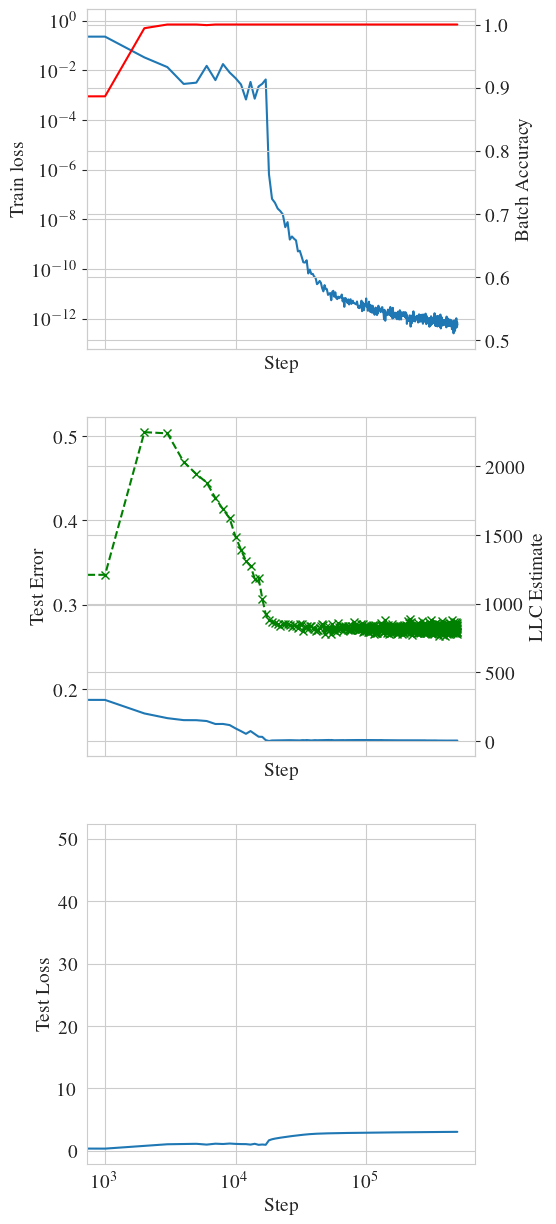

In [75]:
df = df_sgd.copy(deep=True)
# df = df[df["step"] < 10**4]

fig, axes = plt.subplots(3, 1, figsize=(5, 15), sharex=True)
ax = axes[0]
ax.plot(df["step"], df["loss"])
ax.set_ylabel("Train loss")
ax.set_yscale("log")
# ax.set_xscale("log")

ax = ax.twinx()
ax.plot(df["step"], df["batch_acc"], label="Batch Acc", color="r")

ax.set_ylabel("Batch Accuracy")


ax = axes[1]
ax.plot(df["step"], 1 - df["test_acc"], label="Test Error")
ax.set_ylabel("Test Error")
# ax.set_yscale("log")
# ax.set_xscale("log")
if do_llc_estimation:
    ax = ax.twinx()
    yvals = np.clip(df["llc_est"], 0, np.inf)
    ax.plot(df["step"], yvals, "gx--", label="llc_est")
    ax.set_ylabel("LLC Estimate")



ax = axes[2]
ax.plot(df["step"], df["test_loss"], label="Test Loss")
ax.set_ylabel("Test Loss")
# ax.set_yscale("log")
# ax.set_xscale("log")



for ax in axes:
    ax.set_xlabel("Step")
    # ax.set_yscale("log")
    ax.set_xscale("log")


savefig_fn(fig, f"sgd_analysis_id{_ID}.pdf")

Saving file at: ./images/spartan/multitask_sparse_parity/multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314/task_losses_and_errors_id9.pdf


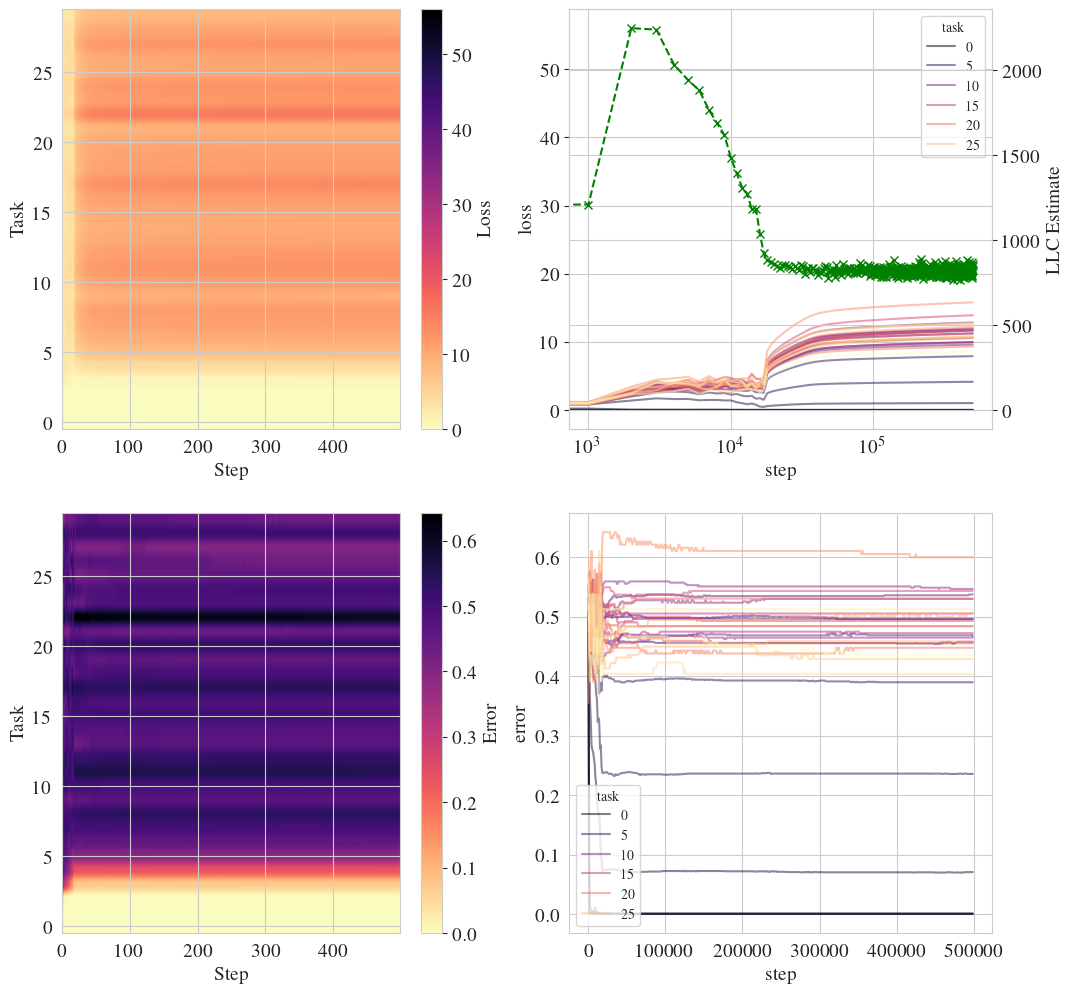

In [76]:
task_losses = df["task_losses"].apply(pd.Series)
task_losses = task_losses.loc[:, sorted(task_losses.columns, reverse=False)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
ax = axes[0]
cax = ax.imshow(task_losses.transpose(), aspect="auto", cmap="magma_r", origin="lower")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Loss")

ax = axes[1]
task_losses["step"] = df["step"]
task_losses = task_losses.melt(id_vars="step", var_name="task", value_name="loss")
sns.lineplot(data=task_losses, x="step", y="loss", hue="task", ax=ax, palette="magma", alpha=0.5)
# ax.set_yscale("log")
ax.set_xscale("log")
if do_llc_estimation:
    ax = ax.twinx()
    yvals = np.clip(df["llc_est"], 0, np.inf)
    ax.plot(df["step"], yvals, "gx--", label="llc_est")
    ax.set_ylabel("LLC Estimate")
    # ax.set_yscale("log")
    ax.set_xscale("log")


ax = axes[2]
task_errors = df["task_errors"].apply(pd.Series)
task_errors = task_errors.loc[:, sorted(task_errors.columns)]
cax = ax.imshow(task_errors.transpose(), aspect="auto", cmap="magma_r", origin="lower")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Error")
# ax.set_xscale("log")

ax = axes[3]
task_errors["step"] = df["step"]
task_errors = task_errors.melt(id_vars="step", var_name="task", value_name="error")
sns.lineplot(data=task_errors, x="step", y="error", hue="task", ax=ax, palette="magma", alpha=0.5)

savefig_fn(fig, f"task_losses_and_errors_id{_ID}.pdf")

Saving file at: ./images/spartan/multitask_sparse_parity/multitasksparseparity_largemlp_width8192_layers1-3_n100000_bs1024_lr0.001_nstep500000_optimadam_llcTrue_traceFalse_202409302314/stage_analysis_id8.pdf


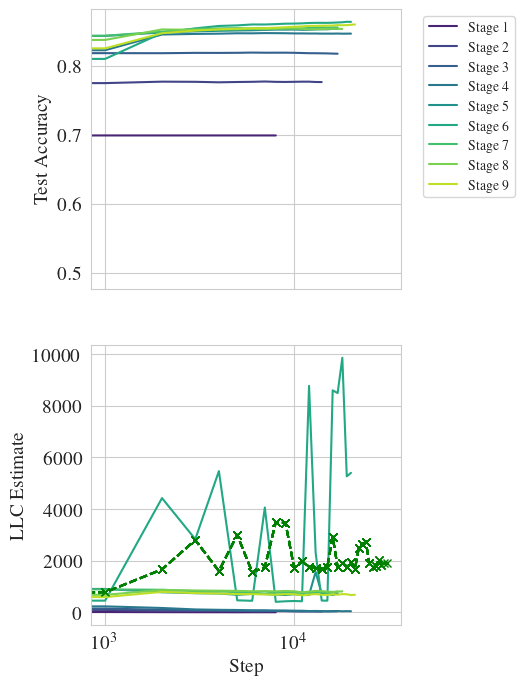

In [71]:
stage_records = expt_info["stage_records"]
num_to_plot = len(stage_records)

with sns.color_palette("viridis", n_colors=num_to_plot):
    fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
    
    for stage, stage_rec in enumerate(stage_records[:num_to_plot], start=1):
        df_stage = pd.DataFrame(stage_rec)
        # df_stage = df_stage[df_stage["step"] > 100]
        ax = axes[0]
        ax.plot(df_stage["step"], df_stage["test_acc"], label=f"Stage {stage}")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.set_xlabel("Step")
        ax.set_ylabel("Test Accuracy")

        ax = axes[1]
        yvals = np.clip(df_stage["llc_est"], 0, np.inf)
        ax.plot(df_stage["step"], yvals, label=f"Stage {stage}")
        
        mask = df["step"] < df_stage["step"].max() * 1.5
        xvals = df[mask]["step"]
        yvals = np.clip(df[mask]["llc_est"], 0, np.inf)
        ax.plot(xvals, yvals, "gx--", label="Full")
        # ax.set_xlim(xmin, xmax)
        ax.set_xlabel("Step")
        ax.set_ylabel("LLC Estimate")

for ax in axes:
    # ax.set_yscale("log")
    ax.set_xscale("log")
    pass

savefig_fn(fig, f"stage_analysis_id{_ID}.pdf")

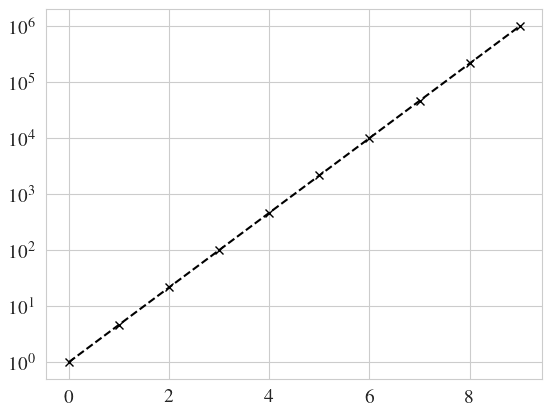

In [89]:
max_num = 10**6
fig, ax = plt.subplots()
ax.plot(np.logspace(0, np.log10(max_num), num=10, base=10), "kx--")
ax.set_yscale("log")

In [99]:
np.linspace(1, 5000, num=6, endpoint=True).astype(int)

array([   1, 1000, 2000, 3000, 4000, 5000])